# Transfer learning with a pretrained MobileNetV2

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import numpy as np

import PIL

import scipy

import pickle

import pandas as pd

from skimage import transform

from PIL import Image

import matplotlib.pyplot as plt

import openpyxl

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, LSTM
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

keras = tf.keras

In [3]:
# If you need to abort this session run the command
# session.close()

Configure directories paths:

In [4]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

### Helper-function for printing confusion matrix


In [5]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix


def print_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    print("Confusion matrix:")

    # Print the confusion matrix as text.
    print(cm)

    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

### Helper-function for plotting example errors

Function for plotting examples of images from the test-set that have been mis-classified.


In [6]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != cls_test)

    # Get the file-paths for images that were incorrectly classified.
    image_paths = np.array(image_paths_test)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:9])

    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]

    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Helper-function for generating and plotting example errors

Function for calculating the predicted classes of the entire test-set and calling the above function to plot a few examples of mis-classified images.

In [7]:
def example_errors():
    # The Keras data-generator for the test-set must be reset
    # before processing. This is because the generator will loop
    # infinitely and keep an internal index into the dataset.
    # So it might start in the middle of the test-set if we do
    # not reset it first. This makes it impossible to match the
    # predicted classes with the input images.
    # If we reset the generator, then it always starts at the
    # beginning so we know exactly which input-images were used.
    generator_test.reset()

    # Predict the classes for all images in the test-set.
    y_pred = new_model.predict_generator(generator_test,
                                         steps=steps_test)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred, axis=1)

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)

    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)

### Helper-function for loading images

The data-set is not loaded into memory, instead it has a list of the files for the images in the training-set and another list of the files for the images in the test-set. This helper-function loads some image-files.

In [8]:
def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

### Helper-function for plotting training history

This plots the classification accuracy and loss-values recorded during training with the Keras API.


In [9]:
def plot_training_history(history):
    # Get the classification accuracy and loss-value
    # for the training-set.
    acc = history.history['categorical_accuracy']
    loss = history.history['loss']

    # Get it for the validation-set (we only use the test-set).
    val_acc = history.history['val_categorical_accuracy']
    val_loss = history.history['val_loss']

    # Plot the accuracy and loss-values for the training-set.
    plt.plot(acc, linestyle='-', color='b', label='Training Acc.')
    plt.plot(loss, 'o', color='b', label='Training Loss')

    # Plot it for the test-set.
    plt.plot(val_acc, linestyle='--', color='r', label='Test Acc.')
    plt.plot(val_loss, 'o', color='r', label='Test Loss')

    # Plot title and legend.
    plt.title('Training and Test Accuracy')
    plt.legend()

    # Ensure the plot shows correctly.
    plt.show()

def plot_images(images, cls_true, cls_pred=None, smooth=True):
    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## Dataset: Collision Avoidance

The Collision-avoidance dataset was introduced in Tutorial #09. It was generated from video-files by taking individual frames and converting them to images.

The directories where the images are now stored.

## Load MobileNetV2 Model

In [10]:
IMG_SIZE = 224 # All images will be resized to 160x160
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


### Input Pipeline

The Keras API has its own way of creating the input pipeline for training a model using files.

First we need to know the shape of the tensors expected as input by the pre-trained VGG16 model. In this case it is images of shape 224 x 224 x 3.

In [11]:
input_shape = base_model.layers[0].output_shape[0][1:3]
input_shape

(224, 224)

In [12]:
def predict(image_path):
    # Load and resize the image using PIL.
    img = PIL.Image.open(image_path)
    img_resized = img.resize(input_shape, PIL.Image.LANCZOS)

    # Plot the image.
    plt.imshow(img_resized)
    plt.show()

    # Convert the PIL image to a numpy-array with the proper shape.
    img_array = np.expand_dims(np.array(img_resized), axis=0)

    # the classes of the ImageNet-dataset.
    pred = base_model.predict(img_array)

## Data preprocessing

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset of 1.4M images and 1000 classes of web images. ImageNet has a fairly arbitrary research training dataset with categories like `jackfruit` and `syringe`, but this base of knowledge will help us tell apart cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. Obviously, the very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to instead depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck features retain much generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

This feature extractor converts each `240x240x3` image to a `5x5x1280` block of features. See what it does to the example batch of images:

## Feature extraction
You will freeze the convolutional base created from the previous step and use that as a feature extractor, add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base
It's important to freeze the convolutional based before you compile and train the model. By freezing (or setting `layer.trainable = False`), you prevent the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to `False` will freeze all the layers.

In [13]:
base_model.trainable = False

In [14]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [16]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
Total params: 2,257,984
Trainable params: 0
Non-trainable params: 2,257,984
_________________________________________________________________


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

Now stack the feature extractor, and these two layers using a `tf.keras.Sequential` model:

### Compile the model

You must compile the model before training it.  Since there are two classes, use a binary cross-entropy loss.

In [17]:
optimizer = Adam(lr=1e-5)
loss = 'categorical_crossentropy'
metrics = ['categorical_accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
Total params: 2,257,984
Trainable params: 0
Non-trainable params: 2,257,984
_________________________________________________________________


In [19]:
# import pydot
# import graphviz
# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='model.png')

The 2.5M parameters in MobileNet are frozen, but there are 1.2K _trainable_ parameters in the Dense layer.  These are divided between two `tf.Variable` objects, the weights and biases.

In [20]:
len(model.trainable_variables)

0

In [21]:
def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, IMG_SHAPE)
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

In [22]:
def generateDFprediction(filename, pred):
    df = pd.DataFrame(data=pred)
    df['file'] = filename
    # reorder file to be the first
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]
    return df

In [23]:
targetdir = '/tf/notebooks/collision_avoidance/data/2020-03-10/images/'
targetfile = 'video-00001-frame-00001.png'
image = load(targetdir+targetfile)
pred = model.predict(image)

allPredsDF = generateDFprediction(targetfile,pred)
allPredsDF

,file,0,1,2,3,4,5,6,7,8,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,video-00001-frame-00001.png,0.786251,0.932391,0.020235,0.0,0.349832,0.0703,0.0,0.00574,0.422425,...,0.190399,1.342812,0.0,1.349095,0.049251,0.038741,1.633435,0.0,0.0,0.509723


In [24]:
def loadOutputVectoresFile(checkfiledir, vectordir, vectorfile):
    cols_headings = ['xmin','xmax', 'ymin', 'ymax', 'zmin', 'zmax']
    df = pd.read_csv(vectordir + vectorfile, sep=" ", header=None , names=cols_headings)
    df['file'] = df.apply(lambda r: framename(checkfiledir,r,vectorfile),axis = 1)
    df['collision'] = df.apply(lambda r: hascollision(r),axis = 1)
    df = df[df.file != "error"]

    # move last two collums to the start
    cols = df.columns.tolist()
    cols = cols[-2:] + cols[:-2]
    
    # return data frame
    return df[cols]
    
    


## Alvaro code start here

In [25]:
once = 1

dataframes_path = '/tf/notebooks/collision_avoidance/data/2020-03-10/dataframes/' #set the path of excels with labels
imagedir = '/tf/notebooks/collision_avoidance/data/2020-03-10/images/' #set the path of the images

#df2 = pd.read_excel('/tf/notebooks/collision_avoidance/data/2020-03-10/dataframes/video-00093.xlsx')

for file in os.listdir(dataframes_path): #iterator of the all the excels in the directory set in previous line
    filename = os.fsdecode(file) #gets the name of the current excel file
    df1 = pd.read_excel(dataframes_path + filename) #reads from the selected excel to panda
    if once: #in the first run our final panda is the same as the first read excel
        df2 = df1 #df2 will be our panda with the data from all the frames
        once = 0
    else:    
        df2 = pd.concat([df2, df1]) #on all the other runs concatenates the data read to the complete panda

df2 = df2.sort_values(by=['file'],ascending=True) #sorts the panda by column 'file' to order all
df2 = df2.set_index('file') # sets the index as the value of the file column

In [26]:
total_images = df2.shape[0] #stors the total number of rows and decreases one that corresponds to the amount of images to annalize
i = 0
once2 = 1

for i in range(total_images): #iterator of all the images in the dataset
    image = load(imagedir+df2.index[i] +'.png') #loads the current image
    pred = model.predict(image) # extracts the indexes of the current image
    currentPredDF = generateDFprediction(df2.index[i],pred) #generates a panda with the current image name and index values
    if once2: # in the first run our final panda only has the values of the first image
        df3 = currentPredDF #df3 will be our panda with the indexes of all the images
        once2 = 0
    else:
        df3 = pd.concat([df3, currentPredDF]) #concatenates the new values extracted to our final panda 
        
df3 = df3 = df3.set_index('file')# sets the index as the value of the file column

In [27]:
df3

,0,1,2,3,4,5,6,7,8,9,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
file,,,,,,,,,,,,,,,,,,,,,
video-00001-frame-00001,0.786251,0.932391,0.020235,0.000000,0.349832,0.070300,0.000000,0.005740,0.422425,0.000000,...,0.190399,1.342812,0.000000,1.349095,0.049251,0.038741,1.633435,0.000000,0.000000,0.509723
video-00001-frame-00002,0.801783,0.941263,0.013003,0.000000,0.330832,0.072481,0.000000,0.018069,0.484924,0.000000,...,0.198060,1.306071,0.000000,1.378013,0.068027,0.027066,1.632540,0.000000,0.000000,0.472858
video-00001-frame-00003,1.103542,0.961378,0.055914,0.000000,0.338212,0.133579,0.000000,0.028236,0.602226,0.000000,...,0.169600,1.272755,0.000000,1.412081,0.080658,0.010565,1.531957,0.000000,0.007590,0.496596
video-00001-frame-00004,1.145320,1.082442,0.082861,0.000000,0.311199,0.240598,0.000000,0.033493,0.657676,0.000000,...,0.152318,1.204189,0.000000,1.409834,0.077321,0.029973,1.521355,0.000000,0.011786,0.439745
video-00001-frame-00005,0.922201,1.006196,0.181207,0.000000,0.055440,0.064056,0.000000,0.603521,0.563548,0.000000,...,0.520549,1.734209,0.163909,0.797820,0.011407,0.023174,2.091522,0.000000,0.038541,0.717560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
video-00093-frame-00270,0.481741,0.020874,0.095051,0.236996,0.000000,0.074085,0.272361,1.642644,1.078457,0.005203,...,1.686909,0.252302,0.088892,0.230210,0.199872,0.138840,0.000000,0.000000,0.000000,0.191500
video-00093-frame-00271,0.249807,0.165509,0.317927,0.000000,0.000000,0.023084,0.000000,1.216358,2.387836,0.000000,...,2.465128,0.111955,0.536321,0.336410,0.005868,0.678973,0.020494,0.000000,0.099867,0.570185
video-00093-frame-00272,0.078397,0.445305,0.695288,0.000000,0.121994,0.252794,0.000000,0.758487,1.318889,0.000000,...,2.802539,0.000000,0.570616,0.033150,0.000000,0.553051,0.000000,0.000000,0.188617,0.339684


In [28]:
finalDF = pd.concat([df2,df3], axis=1) #concatenates our two complete pandas into our goal panda, almost there!!!
finalDF

,collision,xmin,xmax,ymin,ymax,zmin,zmax,0,1,2,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
file,,,,,,,,,,,,,,,,,,,,,
video-00001-frame-00001,0,0.0,0,0.0,0,0,0.0,0.786251,0.932391,0.020235,...,0.190399,1.342812,0.000000,1.349095,0.049251,0.038741,1.633435,0.000000,0.000000,0.509723
video-00001-frame-00002,0,0.0,0,0.0,0,0,0.0,0.801783,0.941263,0.013003,...,0.198060,1.306071,0.000000,1.378013,0.068027,0.027066,1.632540,0.000000,0.000000,0.472858
video-00001-frame-00003,0,0.0,0,0.0,0,0,0.0,1.103542,0.961378,0.055914,...,0.169600,1.272755,0.000000,1.412081,0.080658,0.010565,1.531957,0.000000,0.007590,0.496596
video-00001-frame-00004,0,0.0,0,0.0,0,0,0.0,1.145320,1.082442,0.082861,...,0.152318,1.204189,0.000000,1.409834,0.077321,0.029973,1.521355,0.000000,0.011786,0.439745
video-00001-frame-00005,0,0.0,0,0.0,0,0,0.0,0.922201,1.006196,0.181207,...,0.520549,1.734209,0.163909,0.797820,0.011407,0.023174,2.091522,0.000000,0.038541,0.717560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
video-00093-frame-00270,1,1.0,0,0.0,0,0,1.0,0.481741,0.020874,0.095051,...,1.686909,0.252302,0.088892,0.230210,0.199872,0.138840,0.000000,0.000000,0.000000,0.191500
video-00093-frame-00271,1,1.0,0,0.0,0,0,1.0,0.249807,0.165509,0.317927,...,2.465128,0.111955,0.536321,0.336410,0.005868,0.678973,0.020494,0.000000,0.099867,0.570185
video-00093-frame-00272,1,1.0,0,0.0,0,0,1.0,0.078397,0.445305,0.695288,...,2.802539,0.000000,0.570616,0.033150,0.000000,0.553051,0.000000,0.000000,0.188617,0.339684


In [33]:
del df3

In [34]:
whos

Variable                 Type                            Data/Info
------------------------------------------------------------------
Adam                     ABCMeta                         <class 'tensorflow.python<...>.optimizer_v2.adam.Adam'>
ConfigProto              GeneratedProtocolMessageType    <class 'tensorflow.core.p<...>.config_pb2.ConfigProto'>
Dense                    type                            <class 'tensorflow.python<...>keras.layers.core.Dense'>
Dropout                  type                            <class 'tensorflow.python<...>ras.layers.core.Dropout'>
IMG_SHAPE                tuple                           n=3
IMG_SIZE                 int                             224
Image                    module                          <module 'PIL.Image' from <...>t-packages/PIL/Image.py'>
ImageDataGenerator       type                            <class 'tensorflow.python<...>mage.ImageDataGenerator'>
InteractiveSession       type                            <class 't

In [35]:
#df3 = df3.drop(columns='file') #removes the colums containing the file name in the panda with the indexes
finalDF.to_csv("magia.csv")  #writes our complete panda to a csv! We've made it with no help!!! we can now do the most basic excercise!!

In [239]:
allPredsDF['collision'] = allPredsDF.apply(lambda r: hascollision(r),axis = 1)

,file,0,1,2,3,4,5,6,7,8,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,colision1.mp4137.png,0.317500,0.000000,0.000000,0.004853,0.418067,0.747918,0.106825,0.406478,0.440268,...,0.088718,0.575598,1.084752,1.497329,0.000000,0.106324,0.678758,0.000000,0.010343,1.359165
0,colision33.mp4247.png,0.391994,0.085217,0.000000,0.000796,0.139642,1.211312,0.280736,0.773701,1.646765,...,1.063685,0.000000,0.007774,0.585504,0.000000,0.172585,0.369668,0.314041,0.655741,0.329503
0,colision2.mp4149.png,0.139142,0.007303,0.108824,0.000000,0.357266,0.266568,1.821529,0.000000,0.041968,...,0.585938,0.012980,1.390414,0.658391,0.836434,0.000000,0.000000,0.020382,0.000000,2.002507
0,colision29.mp456.png,0.290980,0.434471,0.000000,0.071705,0.000000,0.478725,0.007908,0.880742,1.375614,...,0.011781,0.020936,0.263574,1.283044,0.000130,0.403409,0.128764,0.684009,0.000000,0.031917
0,colision33.mp4243.png,0.782545,0.136439,0.000000,0.000000,0.024374,0.913641,0.353735,0.789990,1.465371,...,0.951376,0.000000,0.021327,0.737886,0.000000,0.073375,0.403151,0.181134,0.385065,0.367953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,colision16.mp40.png,0.000000,0.437557,0.000000,0.049495,0.137935,0.131697,0.133600,0.029923,0.079207,...,0.632572,0.606480,0.446925,0.239323,0.045444,2.770962,0.480363,0.000000,0.051778,0.054478
0,colision32.mp486.png,0.066289,0.000000,0.273022,0.000000,0.591673,1.153017,0.000000,0.617666,1.604507,...,1.412659,0.042058,0.174474,0.090757,0.184102,1.726528,1.838706,0.188113,0.017208,0.428799
0,colision33.mp4321.png,1.314553,0.000000,0.088222,0.037615,0.483954,1.133165,0.576250,0.682342,1.411868,...,0.388667,0.000000,0.028611,0.303512,0.005704,0.019932,0.741392,0.095567,0.689246,0.238671
0,colision29.mp490.png,0.980198,0.964508,0.035538,0.000000,0.989469,0.378739,0.202859,0.166403,0.212123,...,0.325644,0.282600,0.000000,0.060185,0.604032,0.000000,0.000000,0.000000,1.136220,0.160790


In [228]:
df3.to_excel("features_MobileNetV2.xlsx")

In [349]:
allVectorsDF

,file,collision,xmin,xmax,ymin,ymax,zmin,zmax
0,video-07-frame-00,0,0.0,0.0,0.0,0.0,0.0,0.0
1,video-07-frame-01,0,0.0,0.0,0.0,0.0,0.0,0.0
2,video-07-frame-02,0,0.0,0.0,0.0,0.0,0.0,0.0
3,video-07-frame-03,0,0.0,0.0,0.0,0.0,0.0,0.0
4,video-07-frame-04,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
251,video-02-frame-0251,0,0.0,0.0,0.0,0.0,0.0,0.0
252,video-02-frame-0252,0,0.0,0.0,0.0,0.0,0.0,0.0
253,video-02-frame-0253,0,0.0,0.0,0.0,0.0,0.0,0.0
254,video-02-frame-0254,0,0.0,0.0,0.0,0.0,0.0,0.0


### Load all Outputs to pandas dataframes


In [348]:
import os

outputsdir = 'data/'
checkoutputsdir = 'data/images/all/'
directory = os.fsencode(outputsdir)
checkdirectory = os.fsencode(checkoutputsdir)


allVectorsDF = loadOutputVectoresFile('data/images/all/','data/','Output_colision7.mp4.txt')

i = 0
totalFiles=0
filterEndsWith = "mp4.txt"
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(filterEndsWith): 
        totalFiles=totalFiles+1

        
file_count = len(os.listdir(directory))
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(filterEndsWith): 
        i=i+1
        print(i,'of',totalFiles,dirstring + filename)
        df = generateDFprediction(filename,pred)
        df = loadOutputVectoresFile(checkoutputsdir, outputsdir, filename)
        allVectorsDF = pd.concat([allVectorsDF, df])
        continue
    else:
        continue

1 of 100 /tf/notebooks/collision_avoidance/data/images/all/Output_colision7.mp4.txt
2 of 100 /tf/notebooks/collision_avoidance/data/images/all/Output_colision20.mp4.txt
3 of 100 /tf/notebooks/collision_avoidance/data/images/all/Output_colision16.mp4.txt
4 of 100 /tf/notebooks/collision_avoidance/data/images/all/Output_colision59.mp4.txt
5 of 100 /tf/notebooks/collision_avoidance/data/images/all/Output_colision63.mp4.txt
6 of 100 /tf/notebooks/collision_avoidance/data/images/all/Output_colision96.mp4.txt
7 of 100 /tf/notebooks/collision_avoidance/data/images/all/Output_colision6.mp4.txt
8 of 100 /tf/notebooks/collision_avoidance/data/images/all/Output_colision82.mp4.txt
9 of 100 /tf/notebooks/collision_avoidance/data/images/all/Output_colision14.mp4.txt
10 of 100 /tf/notebooks/collision_avoidance/data/images/all/Output_colision54.mp4.txt
11 of 100 /tf/notebooks/collision_avoidance/data/images/all/Output_colision94.mp4.txt
12 of 100 /tf/notebooks/collision_avoidance/data/images/all/Outpu

100 of 100 /tf/notebooks/collision_avoidance/data/images/all/Output_colision85.mp4.txt


### Generate feature points for all imagens


In [50]:
import os

dirstring = '/tf/notebooks/collision_avoidance/data/images/all/'
directory = os.fsencode(dirstring)

i = 0
file_count = len(os.listdir(directory))
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".png"): 
        i=i+1
        print(i,'of',file_count,dirstring + filename)
        image = load(dirstring + filename)
        pred = model.predict(image)
        df = generateDFprediction(filename,pred)
        allPredsDF = pd.concat([allPredsDF,df])
        continue
    else:
        continue

1 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision35.mp4106.png
2 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision8.mp488.png
3 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision22.mp414.png
4 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision25.mp466.png
5 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision30.mp412.png
6 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision27.mp4366.png
7 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision18.mp4143.png
8 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision4.mp4136.png
9 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision4.mp464.png
10 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision32.mp4539.png
11 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision32.mp4333.png
12 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision32.mp4266.png
13 of 8491 /tf/notebo

106 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision29.mp4181.png
107 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision32.mp462.png
108 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision2.mp4119.png
109 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision32.mp4659.png
110 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision33.mp4157.png
111 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision35.mp4236.png
112 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision31.mp4135.png
113 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision3.mp44.png
114 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision26.mp4200.png
115 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision18.mp410.png
116 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision1.mp448.png
117 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision23.mp454.png
1

209 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision33.mp4193.png
210 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision15.mp474.png
211 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision9.mp4140.png
212 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision19.mp4166.png
213 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision12.mp4114.png
214 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision17.mp4140.png
215 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision35.mp4455.png
216 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision6.mp4195.png
217 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision8.mp487.png
218 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision32.mp4409.png
219 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision35.mp4124.png
220 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision33.mp4353.p

310 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision5.mp460.png
311 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision20.mp464.png
312 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision25.mp4280.png
313 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision16.mp423.png
314 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision4.mp439.png
315 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision30.mp4165.png
316 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision30.mp4115.png
317 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision26.mp4170.png
318 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision35.mp4370.png
319 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision16.mp428.png
320 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision11.mp460.png
321 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision24.mp440.png
3

412 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision22.mp425.png
413 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision4.mp443.png
414 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision32.mp427.png
415 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision1.mp4179.png
416 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision34.mp4122.png
417 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision30.mp4152.png
418 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision24.mp472.png
419 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision4.mp489.png
420 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision35.mp470.png
421 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision26.mp4457.png
422 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision31.mp421.png
423 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision1.mp4164.png
424

516 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision20.mp454.png
517 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision14.mp47.png
518 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision7.mp430.png
519 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision27.mp469.png
520 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision31.mp4223.png
521 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision34.mp488.png
522 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision12.mp423.png
523 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision15.mp475.png
524 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision21.mp4116.png
525 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision30.mp4198.png
526 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision27.mp4139.png
527 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision34.mp4153.png
5

618 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision33.mp48.png
619 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision1.mp4125.png
620 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision22.mp4104.png
621 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision28.mp480.png
622 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision25.mp4342.png
623 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision2.mp4248.png
624 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision24.mp4187.png
625 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision14.mp45.png
626 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision27.mp471.png
627 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision26.mp4104.png
628 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision4.mp492.png
629 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision27.mp4224.png
63

719 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision24.mp4135.png
720 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision18.mp4108.png
721 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision6.mp4196.png
722 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision28.mp4221.png
723 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision24.mp4185.png
724 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision32.mp452.png
725 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision15.mp4132.png
726 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision34.mp4280.png
727 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision30.mp4104.png
728 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision31.mp4379.png
729 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision28.mp417.png
730 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision25.mp4189

819 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision30.mp4124.png
820 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision22.mp485.png
821 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision3.mp4129.png
822 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision15.mp499.png
823 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision15.mp4155.png
824 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision25.mp4319.png
825 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision18.mp438.png
826 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision32.mp4190.png
827 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision4.mp444.png
828 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision16.mp4137.png
829 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision32.mp4217.png
830 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision33.mp452.png

923 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision35.mp4406.png
924 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision19.mp4133.png
925 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision25.mp432.png
926 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision13.mp4163.png
927 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision28.mp4163.png
928 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision35.mp4580.png
929 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision32.mp4472.png
930 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision35.mp4303.png
931 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision33.mp4271.png
932 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision10.mp411.png
933 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision35.mp4641.png
934 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision32.mp459

1025 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision25.mp4154.png
1026 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision13.mp452.png
1027 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision24.mp416.png
1028 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision8.mp430.png
1029 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision3.mp498.png
1030 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision2.mp4153.png
1031 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision35.mp4673.png
1032 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision18.mp484.png
1033 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision26.mp4329.png
1034 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision30.mp46.png
1035 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision23.mp4131.png
1036 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision32.m

1125 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision11.mp450.png
1126 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision17.mp4100.png
1127 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision18.mp4195.png
1128 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision25.mp496.png
1129 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision4.mp484.png
1130 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision34.mp4157.png
1131 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision8.mp496.png
1132 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision29.mp434.png
1133 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision26.mp41.png
1134 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision33.mp4241.png
1135 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision34.mp4204.png
1136 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision27.

1225 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision4.mp4124.png
1226 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision23.mp4113.png
1227 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision25.mp4331.png
1228 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision24.mp475.png
1229 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision18.mp4172.png
1230 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision24.mp4204.png
1231 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision26.mp4107.png
1232 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision33.mp4377.png
1233 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision3.mp450.png
1234 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision31.mp436.png
1235 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision16.mp4139.png
1236 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colisio

1326 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision1.mp4150.png
1327 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision10.mp479.png
1328 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision23.mp460.png
1329 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision26.mp445.png
1330 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision2.mp471.png
1331 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision9.mp440.png
1332 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision13.mp468.png
1333 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision3.mp4165.png
1334 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision25.mp451.png
1335 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision27.mp4150.png
1336 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision32.mp4202.png
1337 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision35.mp

1425 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision18.mp432.png
1426 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision22.mp42.png
1427 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision24.mp439.png
1428 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision26.mp47.png
1429 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision4.mp468.png
1430 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision23.mp410.png
1431 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision12.mp462.png
1432 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision3.mp481.png
1433 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision3.mp4186.png
1434 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision24.mp4231.png
1435 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision18.mp479.png
1436 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision18.mp431

1526 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision35.mp4318.png
1527 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision7.mp424.png
1528 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision33.mp4111.png
1529 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision23.mp4101.png
1530 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision24.mp4184.png
1531 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision9.mp476.png
1532 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision2.mp4142.png
1533 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision33.mp4113.png
1534 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision23.mp458.png
1535 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision29.mp440.png
1536 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision30.mp4133.png
1537 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision3

1624 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision4.mp453.png
1625 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision33.mp4222.png
1626 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision30.mp49.png
1627 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision2.mp4169.png
1628 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision8.mp463.png
1629 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision16.mp452.png
1630 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision34.mp430.png
1631 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision28.mp476.png
1632 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision16.mp458.png
1633 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision26.mp4359.png
1634 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision27.mp4108.png
1635 of 8491 /tf/notebooks/collision_avoidance/data/images/all/colision3.mp4

KeyboardInterrupt: 

In [51]:
allPredsDF

,file,0,1,2,3,4,5,6,7,8,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,colision1.mp4137.png,0.317500,0.000000,0.000000,0.004853,0.418065,0.747917,0.106827,0.406479,0.440271,...,0.088719,0.575599,1.084751,1.497332,0.000000,0.106325,0.678757,0.000000,0.010343,1.359159
0,colision35.mp4106.png,1.284099,0.036421,0.003264,0.985962,0.326687,1.583758,0.893194,0.451254,0.342125,...,0.000000,0.158535,0.002971,0.185176,0.014874,0.982014,1.119179,1.410026,0.005362,0.317402
0,colision8.mp488.png,0.000000,0.000000,0.030063,0.000000,0.000000,2.531765,0.000000,0.011567,0.026465,...,0.656383,0.163958,0.275451,0.001895,0.000000,0.000000,0.357698,0.409793,0.144336,0.246774
0,colision22.mp414.png,1.214126,0.141915,0.546189,0.060635,0.112458,1.508526,0.000000,0.060967,0.282532,...,0.252737,1.309070,0.000000,0.092809,0.040970,0.026804,0.062703,0.000000,0.002475,0.118477
0,colision25.mp466.png,0.384460,0.023800,0.000000,0.064694,0.747383,0.236412,0.009085,0.356383,1.308276,...,0.028641,0.000000,0.144095,0.858225,0.020210,2.187472,0.923868,0.764982,0.000000,0.236719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,colision32.mp429.png,0.824045,0.000000,0.284038,0.079784,0.058551,0.728639,0.005129,0.216315,0.890007,...,0.117439,0.018459,0.664879,0.000000,0.000000,0.000000,1.693841,0.359149,0.445953,2.339256
0,colision26.mp4234.png,0.000000,0.078001,0.006182,0.000000,0.000000,0.024051,0.000000,2.149814,2.104720,...,0.026075,0.039248,0.437025,0.004946,0.284199,0.374151,0.000000,0.014348,0.194947,0.000000
0,colision24.mp469.png,0.000000,1.044477,0.412707,0.130609,0.673022,2.173134,0.009120,1.343695,0.000000,...,0.280647,1.269141,0.189321,0.000000,0.000000,0.685381,0.000000,0.088625,0.011841,0.504252
0,colision19.mp4103.png,0.630324,0.009901,0.616563,0.082082,0.846160,0.002060,0.614681,1.288753,0.883165,...,0.452648,0.544993,0.916080,0.066042,0.000000,1.546925,0.108905,0.000000,0.006207,0.028367


### Train the model

After training for 10 epochs, you should see ~60% accuracy.

<!-- TODO(markdaoust): delete steps_per_epoch in TensorFlow r1.14/r2.0 -->

In [97]:
epochs = 10
steps_per_epoch = 100
history = model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

Instructions for updating:
Please use Model.fit, which supports generators.


ValueError: Input 0 of layer Conv1_pad is incompatible with the layer: expected ndim=4, found ndim=3. Full shape received: [None, 224, 3]

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

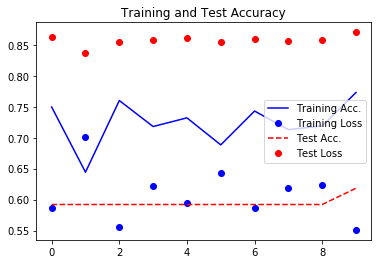

Test-set classification accuracy: 61.84%


In [41]:
plot_training_history(history)
result = model.evaluate_generator(generator_test, steps=steps_test)

print("Test-set classification accuracy: {0:.2%}".format(result[1]))

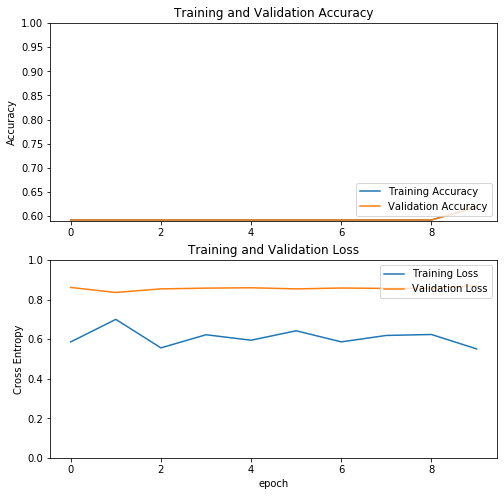

In [42]:
acc = history.history['categorical_accuracy']
val_acc = acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In our feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic features maps to features associated specifically to our dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features which generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [43]:
model.trainable = True

In [44]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


### Compile the model

Compile the model using a much lower training rate.

In [45]:
optimizer_fine = Adam(lr=1e-7)
loss_metric = 'categorical_crossentropy'
metrics = ['categorical_accuracy']
model.compile(optimizer=optimizer_fine, loss=loss_metric, metrics=metrics)

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 1,865,154
Non-trainable params: 395,392
_________________________________________________________________


In [47]:
len(model.trainable_variables)

58

### Continue Train the model

If you trained to convergence earlier, this will get you a few percent more accuracy.

In [ ]:
fine_tune_epochs = 10
initial_epochs = epochs
total_epochs =  initial_epochs + epochs

history_fine = model.fit_generator(generator=generator_train,
                                  initial_epoch =  history.epoch[-1],
                                  epochs=total_epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)


Let's take a look at the learning curves of the training and validation accuracy/loss, when fine tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.


After fine tuning the model nearly reaches 98% accuracy.

In [ ]:
acc += history_fine.history['categorical_accuracy']
val_acc += history_fine.history['val_categorical_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')

plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()